# Reproducibility of host-guest interactions in zeolites from density functional theory and force field approaches

This tutorial reproduces the plots from the following paper:

D. Schwalbe-Koda and R. Gómez-Bombarelli. "Reproducibility of host-guest interactions in zeolites from density functional theory and force field approaches" (2020).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Correlation between binding energies calculated with different methods

Throughout this tutorial, `crystal_id` is a unique identifier for the crystal structure resulting from the calculation. The crystal structures for each of these files is available on the Supporting Data of the paper (Figshare link).

This section reproduces Fig. 2b and Fig. S1 of the paper.

In [2]:
bind = pd.read_csv('data/binding.csv', index_col=0)
bind.head()

,Binding Energy (kJ/mol/OSDA),Host,Guest SMILES,Guests/Cell,Constant,Metric,Theory,Parent ID,Method
crystal_id,,,,,,,,,
137503311,-2034.797917,ACO,NCCN,1,P,opt,FF,83510402,"FF (opt, P)"
137443660,-1232.216981,ACO,NCCN,1,V,opt,FF,83510402,"FF (opt, V)"
84737015,-54.432597,ACO,NCCN,1,P,opt,DFT,83510402,"DFT (opt, P)"
137443660,-39.158782,ACO,NCCN,1,V,frz,FF,83510402,"FF (frz, V)"
137503311,-35.362632,ACO,NCCN,1,P,MD,FF,83510402,"FF (MD, P)"


In [3]:
scatter_data = bind.pivot(
    index='Parent ID',
    columns='Method',
    values='Binding Energy (kJ/mol/OSDA)',    
)

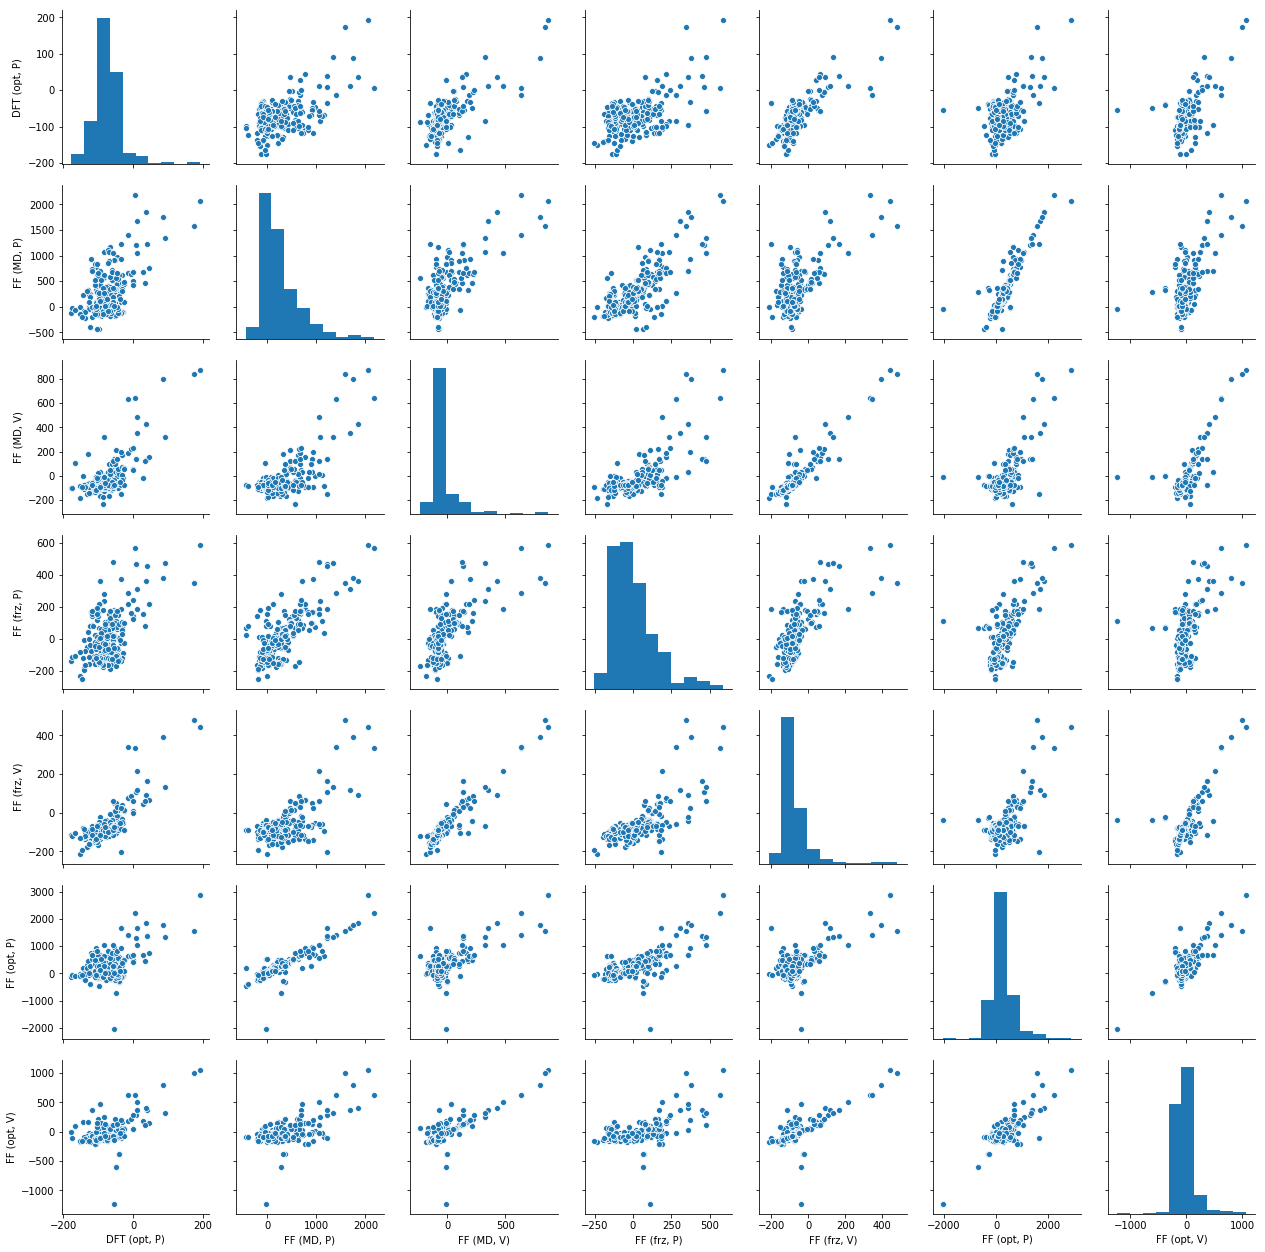

In [4]:
sns.pairplot(scatter_data)
plt.show()

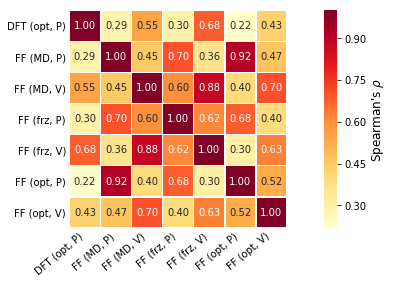

In [5]:
annot_kws = {"fontsize": 10}
grid_kws = {"width_ratios": (.9, .05), "hspace": .3}

fig, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws, figsize=(5, 4))

sns.heatmap(
    scatter_data.corr(method='spearman'),
    square=True,
    cmap="YlOrRd",
    linecolor='w',
    linewidths=0.5,
    annot=True,
    annot_kws=annot_kws,
    fmt=".2f",
    ax=ax,
    cbar=True,
    cbar_ax=cbar_ax,
)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.tick_params(length=0)

cbar_ax.set_ylabel("Spearman's $\\rho$", fontsize=12)

plt.show()

## Differences of energies from different optimizers

This section reproduces Fig. 3 of the paper.

In [6]:
opt = pd.read_csv('data/optimizers.csv', index_col=0)

In [7]:
opt.head()

,Framework,Total Energy (kJ/mol Si),Method,Optimizer
ID,,,,
137326395,ABW,199.135694,MD,Lower + RFO
137344551,ABW,187.275831,opt,BFGS + RFO (G < 0.15)
137344551,ABW,198.346707,MD,BFGS + RFO (G < 0.15)
137326395,ABW,187.275831,opt,Lower + RFO
137352475,ABW,187.275832,opt,BFGS + RFO (G < 0.05)


In [8]:
emin = (opt
    .groupby(['Framework', 'Method'])
    .min()['Total Energy (kJ/mol Si)']
    .to_frame()
    .reset_index()
    .pivot(
        index='Framework',
        columns='Method',
        values='Total Energy (kJ/mol Si)',
    )
)

In [9]:
energies = [
    row['Total Energy (kJ/mol Si)']  - emin.loc[row['Framework'], row['Method']]
    for _, row in opt.iterrows()
]
opt['E - Emin (kJ/mol Si)'] = np.array(energies).clip(min=1e-2)

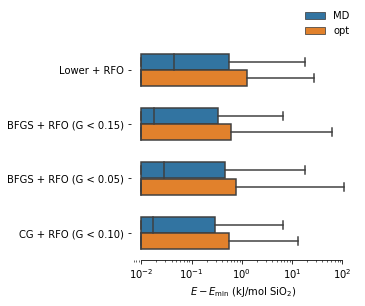

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xscale("log")

sns.boxplot(
    x="E - Emin (kJ/mol Si)",
    y="Optimizer",
    hue="Method",
    data=opt,
    whis=[0, 100],
    width=.6,
    ax=ax,
)

ax.set(ylabel="", xlabel="$E - E_\mathrm{min}$ (kJ/mol SiO$_2$)")
ax.legend(bbox_to_anchor=(0.74, 0.99), frameon=False)

sns.despine(trim=True, left=True)
plt.show()

## Differences of binding energies from different initial conditions

This section reproduces Fig. 4 of the paper.

In [11]:
initial_df = pd.read_csv('data/initial_substrate.csv', index_col=0)

In [12]:
initial_df.head()

,Binding Energy (kJ/mol/OSDA),Host,Guest SMILES,Guests/Cell,Metric,Parent ID,Substrate Theory,Complex
crystal_id,,,,,,,,
137444154,-1249.578876,ACO,NCCN,1,opt,83510401,DFT,"ACO,NCCN"
137371716,-66.284927,ACO,NCCN,2,frz,83510405,DFT,"ACO,NCCN"
137352989,-32.625758,ACO,NCCN,2,MD,83510406,DFT,"ACO,NCCN"
137335164,-326.908102,AEL,CC(C)NC(C)C,1,MD,87639868,DFT,"AEL,CC(C)NC(C)C"
137319294,-157.131315,AEL,CC(C)NC(C)C,2,opt,87639872,DFT,"AEL,CC(C)NC(C)C"


In [13]:
data = (initial_df
    .loc[initial_df['Metric'] == 'opt']
    .pivot(index='Complex', columns='Substrate Theory', values='Binding Energy (kJ/mol/OSDA)')
)

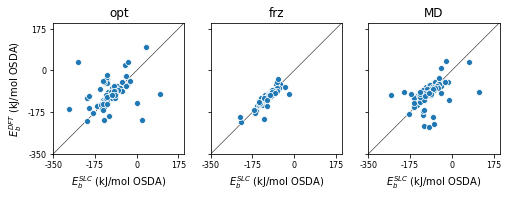

In [14]:
fig, ax_fig = plt.subplots(1, 3, figsize=(8, 6), sharey=True)

lims = np.array([-350, 200])

ticks = np.arange(lims[0], lims[1] + 1, 175)

metrics = initial_df['Metric'].unique()

for ax, metric in zip(ax_fig, metrics):
    data = (initial_df
        .loc[initial_df['Metric'] == metric]
        .pivot(index='Complex', columns='Substrate Theory', values='Binding Energy (kJ/mol/OSDA)')
        .dropna()
    )
    
    sns.scatterplot(
        x='SLC',
        y='DFT',
        ax=ax,
        data=data,
    )
    
    ax.plot(
        lims, lims,
        linewidth=0.5,
        color='black',
        zorder=-1,
    )
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal')
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ax.get_xticks(), size=8)
    ax.set_yticklabels(ax.get_yticks(), size=8)
    
    ax.set_xlabel('$E_b^{SLC}$ (kJ/mol OSDA)', fontsize=10)
    
    ax.set_title(metric)

ax_fig[0].set_ylabel('$E_b^{DFT}$ (kJ/mol OSDA)', fontsize=10)
plt.show()